In [1]:
# Activation Patching Experiments
# Minimal pair patching to identify directional update circuits

import torch
import pandas as pd
from utils.grid_utils import *
from utils.model_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/model_chunked/checkpoint-73125"
model, tokenizer = load_model_and_tokenizer(MODEL_PATH)

def generate_minimal_pair_case():
    """Generate prompts identical except for final direction."""
    while True:
        G = get_grid_graph(generate_random_names(16), size=4)
        walk = generate_random_walk(G, random.choice(list(G.nodes())), 120)
        
        for i in range(len(walk) - 2, 5, -1):
            node = walk[i]
            successors = list(G.successors(node))
            if len(successors) >= 2:
                base_prompt_walk = walk[:i+1]
                base_prompt_str = walk_to_string(base_prompt_walk, G)
                
                direction1 = G.edges[node, successors[0]]['direction']
                target1 = successors[0]
                direction2 = G.edges[node, successors[1]]['direction']
                target2 = successors[1]
                
                return {
                    "base_prompt": base_prompt_str,
                    "clean_direction": direction1,
                    "clean_prompt": f"{base_prompt_str} {direction1}",
                    "expected_clean_prediction": target1,
                    "corrupt_direction": direction2,
                    "corrupt_prompt": f"{base_prompt_str} {direction2}",
                    "expected_corrupt_prediction": target2,
                }

def run_patching_experiment(model, tokenizer, test_case, target_layer, component_type):
    """Run patching experiment for given layer and component."""
    clean_tokens = tokenizer(test_case['clean_prompt'], return_tensors="pt").to(DEVICE)
    corrupt_tokens = tokenizer(test_case['corrupt_prompt'], return_tensors="pt").to(DEVICE)
    
    clean_direction_pos = find_token_position(clean_tokens, test_case['clean_direction'], tokenizer)
    corrupt_direction_pos = find_token_position(corrupt_tokens, test_case['corrupt_direction'], tokenizer)
    
    # Get patch vector
    cache = {}
    def capture_hook(_, __, output):
        if component_type == 'attention':
            cache['output'] = output[0][0, corrupt_direction_pos, :].detach()
        else:
            cache['output'] = output[0, corrupt_direction_pos, :].detach()
    
    target_module = model.transformer.h[target_layer].attn if component_type == 'attention' else model.transformer.h[target_layer].mlp
    hook = target_module.register_forward_hook(capture_hook)
    with torch.no_grad():
        model(**corrupt_tokens)
    hook.remove()
    patch_vector = cache['output']
    
    # Run patched experiment
    with ComponentPatcher(model, target_layer, component_type, patch_vector, clean_direction_pos):
        with torch.no_grad():
            patched_outputs = model(**clean_tokens)
    
    patched_logits = patched_outputs.logits[0, clean_direction_pos, :]
    predicted_id = torch.argmax(patched_logits).item()
    predicted_token = tokenizer.decode(predicted_id).strip()
    
    return predicted_token

def run_systematic_patching():
    """Run patching across all layers for both MLP and attention."""
    test_case = generate_minimal_pair_case()
    results = []
    
    for layer_idx in range(model.config.n_layer):
        for component in ['mlp', 'attention']:
            try:
                pred = run_patching_experiment(model, tokenizer, test_case, layer_idx, component)
                success = pred == test_case['expected_corrupt_prediction']
                results.append({
                    'Layer': layer_idx,
                    'Component': component,
                    'Prediction': pred,
                    'Success': success
                })
            except Exception as e:
                results.append({
                    'Layer': layer_idx,
                    'Component': component,
                    'Prediction': 'ERROR',
                    'Success': False
                })
    
    return pd.DataFrame(results)


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Run experiments
print("Running systematic patching...")
systematic_results = run_systematic_patching()
print(systematic_results)



Running systematic patching...
    Layer  Component Prediction  Success
0       0        mlp         br    False
1       0  attention         da     True
2       1        mlp         br    False
3       1  attention         br    False
4       2        mlp         br    False
5       2  attention         br    False
6       3        mlp         br    False
7       3  attention         br    False
8       4        mlp         br    False
9       4  attention         br    False
10      5        mlp         br    False
11      5  attention         br    False
12      6        mlp         br    False
13      6  attention         br    False
14      7        mlp         br    False
15      7  attention         br    False
16      8        mlp         br    False
17      8  attention         br    False
18      9        mlp         br    False
19      9  attention         br    False
20     10        mlp         br    False
21     10  attention         br    False
22     11        mlp      

Running Trials:   0%|          | 0/1000 [00:00<?, ?it/s]

Running Trials: 100%|██████████| 1000/1000 [00:13<00:00, 73.79it/s]




--- SUMMARY (N=1000 trials) ---
Final Tally of Outcomes:
  Recipient moves in donor direction: 960 / 1000 times (96.0%)
  Recipient copies donor destination:        29 / 1000 times (2.9%)
  Other Result:                              11 / 1000 times (1.1%)


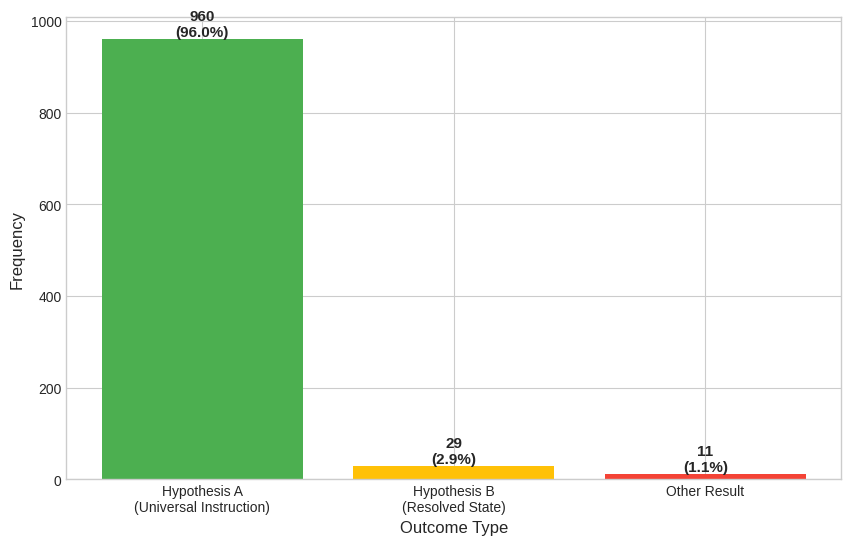

In [3]:
import pandas as pd
from tqdm.auto import tqdm

def generate_independent_test_case():
    """
    Generates cross-context test cases with final direction tokens.
    Ensures donor and recipient have different directions for meaningful patching.
    """
    max_attempts = 100
    
    for attempt in range(max_attempts):
        try:
            # Generate two independent contexts
            G_A = get_grid_graph(generate_random_names(16), size=4)
            walk_A = generate_random_walk(G_A, random.choice(list(G_A.nodes())), 120)
            
            # Use the FINAL direction token for context A
            final_node_A = walk_A[-1]
            neighbors_A = list(G_A.successors(final_node_A))
            if len(neighbors_A) < 2:
                continue
            
            direction_A = G_A.edges[final_node_A, neighbors_A[0]]['direction']
            target_A = neighbors_A[0]
            prompt_A = walk_to_string(walk_A, G_A) + f" {direction_A}"

            G_B = get_grid_graph(generate_random_names(16), size=4)
            walk_B = generate_random_walk(G_B, random.choice(list(G_B.nodes())), 120)
            
            # Use the FINAL direction token for context B
            final_node_B = walk_B[-1]
            neighbors_B = list(G_B.successors(final_node_B))
            if len(neighbors_B) < 2:
                continue
            
            direction_B = G_B.edges[final_node_B, neighbors_B[0]]['direction']
            target_B = neighbors_B[0]
            prompt_B = walk_to_string(walk_B, G_B) + f" {direction_B}"

            # Ensure directions are different
            if direction_A == direction_B:
                continue
            
            # Find expected universal outcome (move in donor direction from recipient)
            expected_outcome_A = None
            for neighbor in G_B.successors(final_node_B):
                if G_B.edges[final_node_B, neighbor]['direction'] == direction_A:
                    expected_outcome_A = neighbor
                    break
            
            # Validate the test case
            if (expected_outcome_A is not None and 
                expected_outcome_A != target_B and 
                expected_outcome_A != target_A):
                
                return {
                    "prompt_A": prompt_A,
                    "direction_A": direction_A,
                    "node_A_end": target_A,
                    "prompt_B": prompt_B,
                    "direction_B": direction_B,
                    "node_B_end": target_B,
                    "expected_outcome_A": expected_outcome_A,  # Universal: move in donor direction
                    "expected_outcome_B": target_A,            # Resolved: copy donor's target
                }
            
        except Exception as e:
            continue
    
    raise ValueError(f"Failed to generate valid test case after {max_attempts} attempts")
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def cross_context_patching(model, tokenizer, num_runs=1000):
    """
    Runs the universal vector experiment many times to get a statistical measure of behavior.
    """
    
    outcomes = {'A': 0, 'B': 0, 'Unexpected': 0}

    for i in tqdm(range(num_runs), desc="Running Trials"):

        TARGET_LAYER = 0

        try:
            test_case = generate_independent_test_case()
        except (RecursionError, TypeError) as e:
            print(f"Test case generation failed: {e}")
            continue

        # 1. Get Patch Vector from Donor A
        tokens_A = tokenizer(test_case["prompt_A"], return_tensors="pt").to(DEVICE)
        pos_A = find_token_position(tokens_A, test_case["direction_A"], tokenizer)
        
        attn_outputs_cache = []
        target_attn_module = model.transformer.h[TARGET_LAYER].attn
        def attn_hook(_, __, output): attn_outputs_cache.append(output[0])
        hook = target_attn_module.register_forward_hook(attn_hook)
        with torch.no_grad(): model(**tokens_A)
        hook.remove()
        
        # Handle cases where the hook might not fire as expected
        if not attn_outputs_cache:
            print("Attention hook did not fire, skipping trial.")
            outcomes['Unexpected'] += 1
            continue
        patch_vector = attn_outputs_cache[0][0, pos_A, :].detach()

        # 2. Run Patched Pass on Recipient B
        tokens_B = tokenizer(test_case["prompt_B"], return_tensors="pt").to(DEVICE)
        pos_B = find_token_position(tokens_B, test_case["direction_B"], tokenizer)

        with ComponentPatcher(model, TARGET_LAYER, 'attention', patch_vector, pos_B):
            with torch.no_grad():
                patched_outputs = model(**tokens_B)
        
        last_token_logits = patched_outputs.logits[0, pos_B, :]
        predicted_token = tokenizer.decode(torch.argmax(last_token_logits).item()).strip()

        # 3. Analyze and store the result for this run
        if predicted_token == test_case['expected_outcome_A']:
            outcomes['A'] += 1
        elif predicted_token == test_case['expected_outcome_B']:
            outcomes['B'] += 1
        else:
            outcomes['Unexpected'] += 1

    # --- Final Summary Across All Runs ---
    print("\n\n" + "="*50)
    print(f"--- SUMMARY (N={num_runs} trials) ---")
    print("="*50)
    
    total_runs = sum(outcomes.values())
    
    # Calculate percentages
    percent_A = (outcomes['A'] / total_runs) * 100 if total_runs > 0 else 0
    percent_B = (outcomes['B'] / total_runs) * 100 if total_runs > 0 else 0
    percent_U = (outcomes['Unexpected'] / total_runs) * 100 if total_runs > 0 else 0

    print("Final Tally of Outcomes:")
    print(f"  Recipient moves in donor direction: {outcomes['A']:>3} / {total_runs} times ({percent_A:.1f}%)")
    print(f"  Recipient copies donor destination:       {outcomes['B']:>3} / {total_runs} times ({percent_B:.1f}%)")
    print(f"  Other Result:                             {outcomes['Unexpected']:>3} / {total_runs} times ({percent_U:.1f}%)")
    
    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    labels = ['Hypothesis A\n(Universal Instruction)', 'Hypothesis B\n(Resolved State)', 'Other Result']
    counts = [outcomes['A'], outcomes['B'], outcomes['Unexpected']]
    percentages = [percent_A, percent_B, percent_U]
    
    bars = ax.bar(labels, counts, color=['#4CAF50', '#FFC107', '#F44336'])
    
    #ax.set_title(f'Distribution of Outcomes for Cross-Context Attention Patching (N={total_runs})', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xlabel('Outcome Type', fontsize=12)
    
    # Add text labels for counts and percentages
    for bar, count, percent in zip(bars, counts, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{count}\n({percent:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.show()

# run experiment
cross_context_patching(model, tokenizer, num_runs=1000)


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Visualizing attention from query token 'EAST' at position 7.


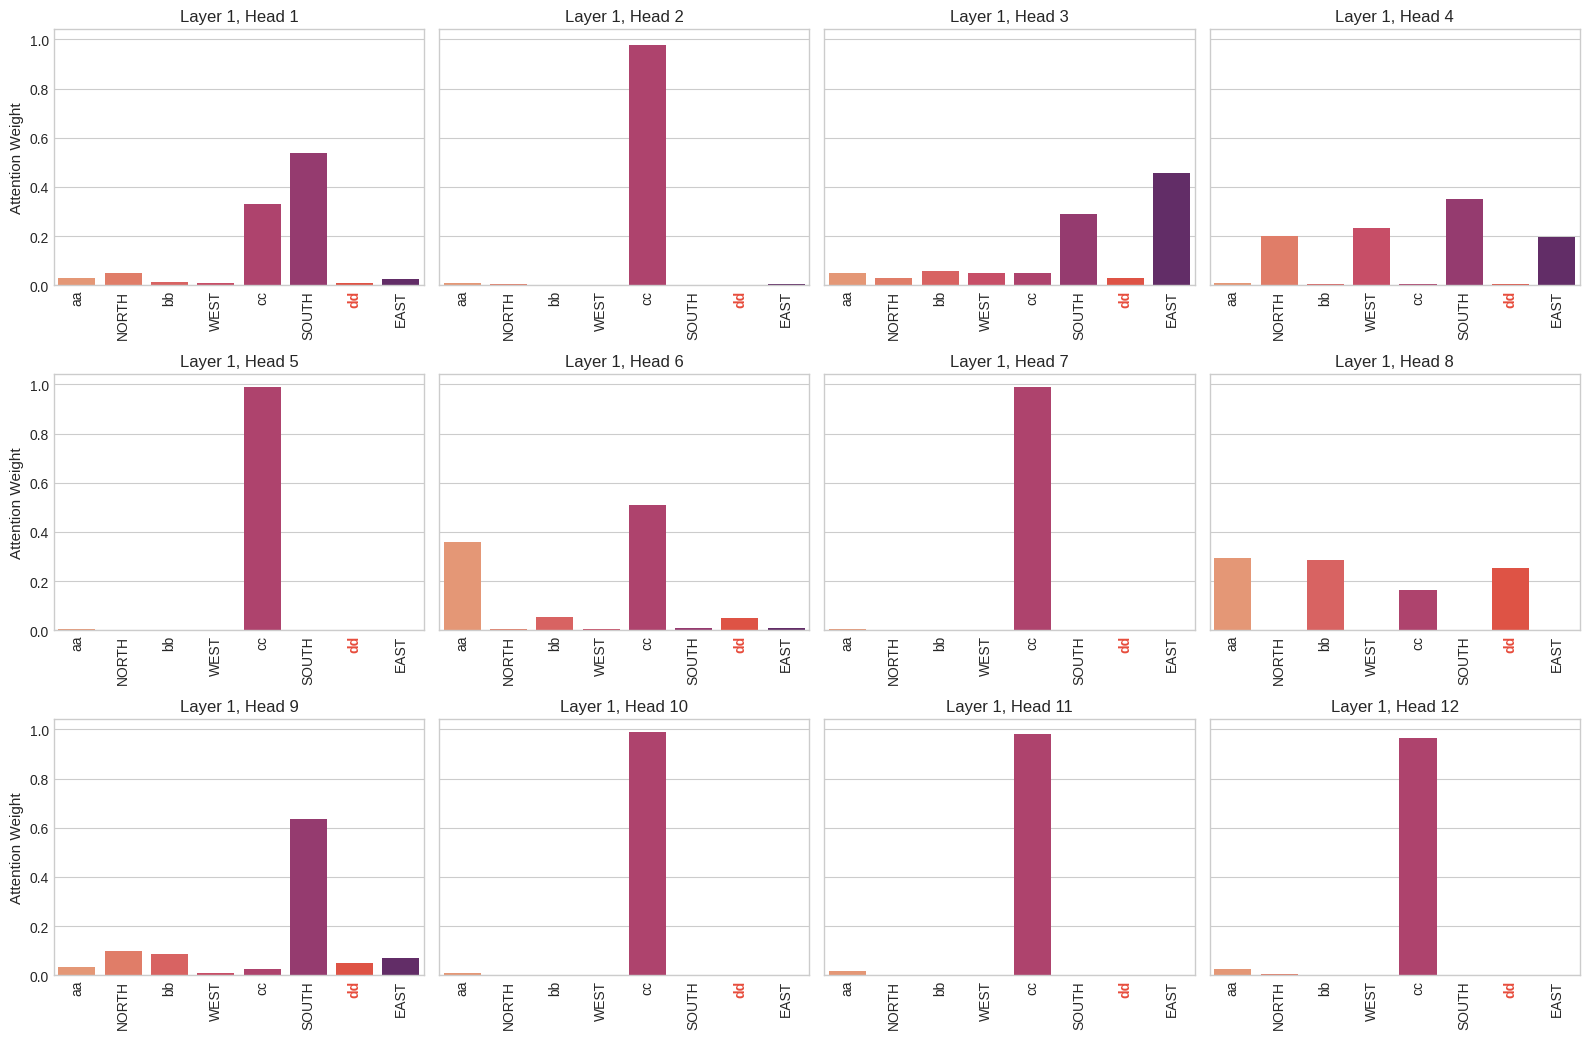

In [4]:
def visualize_l0_head_patterns(model, tokenizer, head_indices_to_show, max_plots_per_row=4):
    """
    Generates a prompt and visualizes attention patterns for specific heads in Layer 1.
    """
    
    prompt = " aa NORTH bb WEST cc SOUTH dd EAST"
    tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)
    
    l0_attentions = outputs.attentions[0].cpu().squeeze(0)
    token_list = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    
    query_pos = -1
    for i, token_str in enumerate(token_list):
        if 'EAST' in token_str:
            query_pos = i
            
    if query_pos == -1:
        print("Could not find 'EAST' in the prompt for visualization.")
        return

    key_pos = query_pos - 1 if query_pos > 0 else -1
    print(f"Visualizing attention from query token '{token_list[query_pos]}' at position {query_pos}.")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    num_heads = len(head_indices_to_show)
    num_cols = min(num_heads, max_plots_per_row)
    num_rows = (num_heads + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3.5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()

    palette = sns.color_palette("flare", n_colors=len(token_list))
    highlight_color = '#e74c3c'

    for i, head_idx in enumerate(head_indices_to_show):
        ax = axes[i]
        attention_scores = l0_attentions[head_idx, query_pos, :].numpy()
        
        bar_colors = [highlight_color if j == key_pos else palette[j] for j in range(len(token_list))]
        
        sns.barplot(
            x=list(range(len(token_list))),
            y=attention_scores,
            ax=ax,
            hue=list(range(len(token_list))),
            palette=bar_colors,
            saturation=0.9,
            legend=False
        )

        ax.set_xticks(range(len(token_list)))
        ax.set_xticklabels(token_list, rotation=90)
        
        ax.set_title(f"Layer 1, Head {head_idx + 1}", fontsize=12)
        ax.tick_params(axis='y', labelsize=10)
        
        if key_pos != -1:
            key_tick = ax.get_xticklabels()[key_pos]
            key_tick.set_color(highlight_color)
            key_tick.set_fontweight('bold')
        
        if i % num_cols == 0:
            ax.set_ylabel("Attention Weight", fontsize=11)
        else:
            ax.set_ylabel("")

    for i in range(num_heads, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()

    
    plt.show()

# run visualization
core_head_indices = list(range(12)) 
visualize_l0_head_patterns(model, tokenizer, head_indices_to_show=core_head_indices, max_plots_per_row=4)

ROBUST HEAD REDUNDANCY ANALYSIS: CROSS-CONTEXT PATCHING
Testing across 1000 test cases with 60.0% success threshold
Generating test cases (showing first 5)...
Test case 1: WEST -> bz
Test case 2: WEST -> ap
Test case 3: WEST -> iu
Test case 4: WEST -> dx
Test case 5: WEST -> sm

Generated 1000 valid test cases

Testing 1-head combinations...


Found 6 successful 1-head combinations

REDUNDANCY ANALYSIS RESULTS
Minimum heads needed: 1
Minimal combinations: 6
Test cases used: 1000
Redundancy ratio: 0.500
(6 out of 12 possible combinations work)

Successful combinations (with success rates):
  1. (1,) (rate: 0.792, 792/1000)
  2. (3,) (rate: 0.761, 761/1000)
  3. (9,) (rate: 0.815, 815/1000)
  4. (10,) (rate: 0.721, 721/1000)
  5. (11,) (rate: 0.663, 663/1000)
  6. (12,) (rate: 0.708, 708/1000)

Head frequency in successful combinations:
  Head 1: 1 times
  Head 3: 1 times
  Head 9: 1 times
  Head 10: 1 times
  Head 11: 1 times
  Head 12: 1 times

Visualizing success rates of individual specialist heads...


/tmp/ipykernel_2119385/2370540105.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=labels, y=rates, ax=ax, palette='viridis')


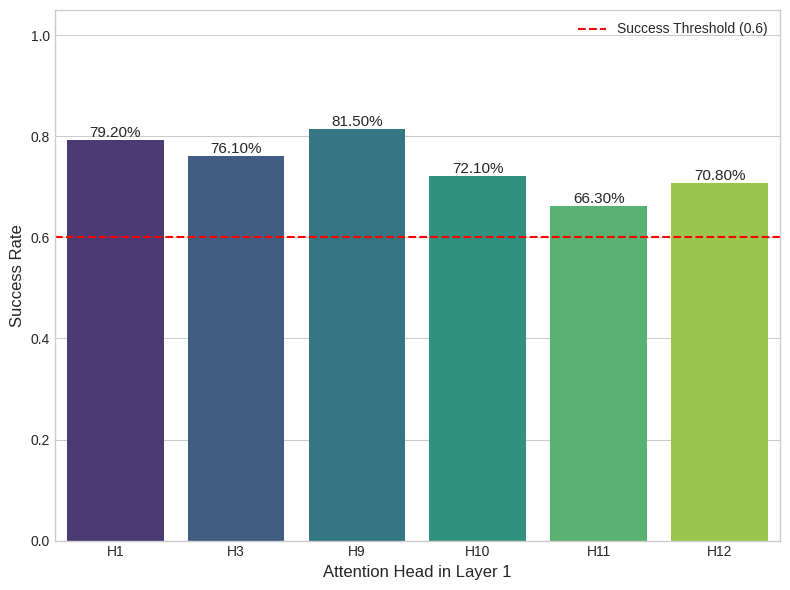

In [14]:
# Head Redundancy Analysis for Cross-Context Patching
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

def test_head_combinations(model, tokenizer, num_test_cases=100, min_success_rate=0.8):
    """Test different head combinations across multiple test cases for robust redundancy analysis."""
    TARGET_LAYER = 0
    num_heads = model.config.n_head
    head_dim = model.config.n_embd // num_heads
    
    print("="*70)
    print("ROBUST HEAD REDUNDANCY ANALYSIS: CROSS-CONTEXT PATCHING")
    print(f"Testing across {num_test_cases} test cases with {min_success_rate*100}% success threshold")
    print("="*70)
    
    # Generate multiple test cases
    test_cases = []
    print("Generating test cases (showing first 5)...")
    for i in range(num_test_cases):
        try:
            test_case = generate_independent_test_case()
            test_cases.append(test_case)
            if i < 5:
                print(f"Test case {i+1}: {test_case['direction_A']} -> {test_case['expected_outcome_A']}")
        except Exception as e:
            if i < 5:
                print(f"Failed to generate test case {i+1}: {e}")
            continue
    
    if len(test_cases) < 3:
        print("Need at least 3 test cases for robust analysis!")
        return
    
    print(f"\nGenerated {len(test_cases)} valid test cases")
    print("="*70)

    successful_combinations = []
    
    for size in range(1, num_heads + 1):
        print(f"\nTesting {size}-head combinations...")
        size_successful = []
        
        all_combos = list(itertools.combinations(range(num_heads), size))
        
        for combo in tqdm(all_combos, desc=f"Testing {size}-head combinations", leave=False):
            heads_to_patch = list(combo)
            successes = 0
            total_tests = 0
            
            for test_case in test_cases:
                try:
                    donor_tokens = tokenizer(test_case["prompt_A"], return_tensors="pt").to(DEVICE)
                    donor_direction_pos = find_token_position(donor_tokens, test_case["direction_A"], tokenizer)
                    
                    attn_outputs_cache = []
                    hook = model.transformer.h[TARGET_LAYER].attn.register_forward_hook(
                        lambda _, __, output: attn_outputs_cache.append(output[0])
                    )
                    with torch.no_grad():
                        model(**donor_tokens)
                    hook.remove()
                    donor_attn_output = attn_outputs_cache[0]
                    
                    combined_patch = torch.zeros_like(donor_attn_output)
                    for head_idx in heads_to_patch:
                        start_idx = head_idx * head_dim
                        end_idx = (head_idx + 1) * head_dim
                        head_output = donor_attn_output[:, :, start_idx:end_idx].detach()
                        combined_patch[:, :, start_idx:end_idx] = head_output
                    
                    patch_vector = combined_patch[0, donor_direction_pos, :].detach()
                    
                    recipient_tokens = tokenizer(test_case["prompt_B"], return_tensors="pt").to(DEVICE)
                    recipient_direction_pos = find_token_position(recipient_tokens, test_case["direction_B"], tokenizer)
                    
                    with ComponentPatcher(model, TARGET_LAYER, 'attention', patch_vector, recipient_direction_pos):
                        with torch.no_grad():
                            patched_outputs = model(**recipient_tokens)
                    
                    patched_logits = patched_outputs.logits[0, recipient_direction_pos, :]
                    predicted_token = tokenizer.decode(torch.argmax(patched_logits).item()).strip()
                    
                    if predicted_token == test_case['expected_outcome_A']:
                        successes += 1
                    total_tests += 1
                    
                    del donor_tokens, recipient_tokens, donor_attn_output, combined_patch, patch_vector
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        
                except Exception as e:
                    continue
            
            if total_tests > 0:
                success_rate = successes / total_tests
                if success_rate >= min_success_rate:
                    size_successful.append({
                        'combination': combo,
                        'size': size,
                        'success_rate': success_rate,
                        'successes': successes,
                        'total_tests': total_tests
                    })
        
        if size_successful:
            successful_combinations.extend(size_successful)
            print(f"Found {len(size_successful)} successful {size}-head combinations")
            break
        else:
            print(f"No successful {size}-head combinations found")
    
    if not successful_combinations:
        print("No successful combinations found!")
        return
    
    min_size = min(combo['size'] for combo in successful_combinations)
    minimal_combinations = [combo for combo in successful_combinations if combo['size'] == min_size]
    
    print(f"\n" + "="*70)
    print("REDUNDANCY ANALYSIS RESULTS")
    print("="*70)
    print(f"Minimum heads needed: {min_size}")
    print(f"Minimal combinations: {len(minimal_combinations)}")
    print(f"Test cases used: {len(test_cases)}")
    
    total_possible = len(list(itertools.combinations(range(num_heads), min_size)))
    redundancy_ratio = len(minimal_combinations) / total_possible
    
    print(f"Redundancy ratio: {redundancy_ratio:.3f}")
    print(f"({len(minimal_combinations)} out of {total_possible} possible combinations work)")
    
    print(f"\nSuccessful combinations (with success rates):")
    for i, combo in enumerate(minimal_combinations[:10]):
        combo_1_indexed = tuple(h + 1 for h in combo['combination'])
        print(f"  {i+1}. {combo_1_indexed} (rate: {combo['success_rate']:.3f}, {combo['successes']}/{combo['total_tests']})")
    if len(minimal_combinations) > 10:
        print(f"  ... and {len(minimal_combinations) - 10} more")
    
    head_counts = Counter()
    for combo in minimal_combinations:
        for head in combo['combination']:
            head_counts[head] += 1
    
    print(f"\nHead frequency in successful combinations:")
    for head, count in sorted(head_counts.items()):
        print(f"  Head {head + 1}: {count} times")
    
    if minimal_combinations:
        if min_size == 1:
            # If we only have 1-head combinations, a single bar chart of success rates is best.
            print("\nVisualizing success rates of individual specialist heads...")
            
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # Prepare data for the plot
            plot_data = sorted(minimal_combinations, key=lambda x: x['combination'])
            labels = [f"H{c['combination'][0] + 1}" for c in plot_data]
            rates = [c['success_rate'] for c in plot_data]
            
            bars = sns.barplot(x=labels, y=rates, ax=ax, palette='viridis')
            #ax.set_title('Success Rate of Individual Heads', fontsize=16)
            ax.set_xlabel('Attention Head in Layer 1', fontsize=12)
            ax.set_ylabel('Success Rate', fontsize=12)
            ax.set_ylim(0, 1.05)
            
            # Add the success threshold line
            ax.axhline(min_success_rate, color='red', linestyle='--', label=f'Success Threshold ({min_success_rate})')
            ax.legend()
            
            # Add text labels on top of each bar
            for bar in bars.patches:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        bar.get_height(),
                        f'{bar.get_height():.2%}',
                        ha='center', va='bottom',
                        fontsize=11)
            
            plt.tight_layout()
            plt.show()

        else:
            # If minimal size > 1, the original two-plot layout is more informative.
            print("\nVisualizing frequency and distribution for multi-head circuits...")
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            sorted_heads_0_indexed = sorted(head_counts.keys())
            labels_1_indexed = [f"H{h+1}" for h in sorted_heads_0_indexed]
            frequencies = [head_counts[h] for h in sorted_heads_0_indexed]
            
            ax1.bar(labels_1_indexed, frequencies)
            ax1.set_xlabel('Head Index (1-12)')
            ax1.set_ylabel('Frequency in Successful Combinations')
            ax1.set_title(f'Head Importance in {min_size}-Head Combinations')
            
            success_rates = [combo['success_rate'] for combo in minimal_combinations]
            ax2.hist(success_rates, bins=10, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Success Rate')
            ax2.set_ylabel('Number of Combinations')
            ax2.set_title('Distribution of Success Rates')
            ax2.axvline(min_success_rate, color='red', linestyle='--', label=f'Threshold ({min_success_rate})')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    return successful_combinations, minimal_combinations

# Execute robust analysis
results = test_head_combinations(model, tokenizer, num_test_cases=1000, min_success_rate=0.6)

Generating test cases...
Calculating baseline...
Baseline: 0.980
Testing 1-layer ablations...


Testing 2-layer ablations...


Testing 3-layer ablations...


Testing 4-layer ablations...


Testing 5-layer ablations...


Testing 6-layer ablations...


Testing 7-layer ablations...


Testing 8-layer ablations...


Testing 9-layer ablations...


Testing 10-layer ablations...


Testing 11-layer ablations...


/tmp/ipykernel_2119385/2875508800.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='layers_ablated', y='accuracy', data=results_df, palette='viridis')


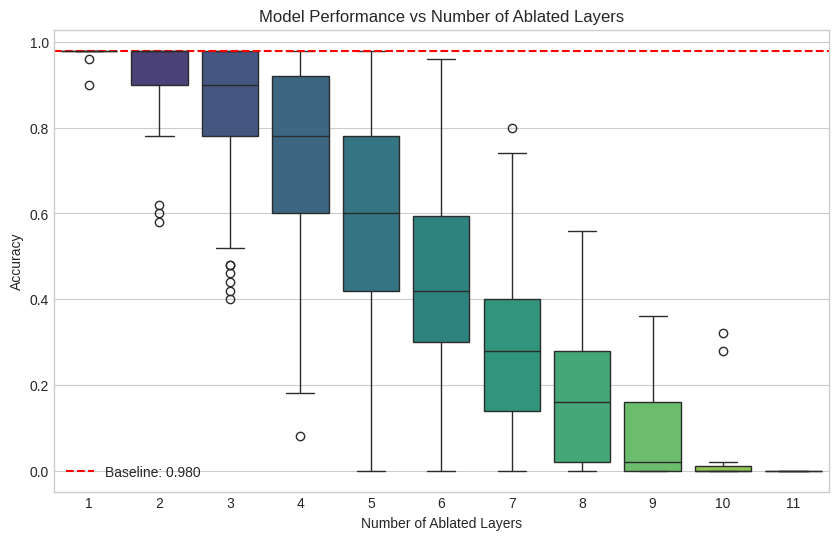


Breaking point: 3 layers
Minimal required: 9 layers


In [15]:
# Layer Ablation Analysis: Testing Layer Redundancy

import itertools
from contextlib import ExitStack
import matplotlib.pyplot as plt
import seaborn as sns

def run_layer_ablation_analysis(model, tokenizer, num_test_cases=50):
    """Test all combinations of layer ablation to find minimal required layers."""
    print("Generating test cases...")
    test_cases = [generate_minimal_pair_case() for _ in range(num_test_cases)]
    
    # Get baseline accuracy
    print("Calculating baseline...")
    correct = 0
    with torch.no_grad():
        for case in test_cases:
            tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
            logits = model(**tokens).logits
            pred = tokenizer.decode(torch.argmax(logits[0, -1, :]).item()).strip()
            if pred == case['expected_clean_prediction']:
                correct += 1
    baseline = correct / num_test_cases
    print(f"Baseline: {baseline:.3f}")

    # Test all layer combinations
    all_layers = list(range(1, model.config.n_layer))  # Skip Layer 0
    results = []
    
    for k in range(1, len(all_layers) + 1):
        print(f"Testing {k}-layer ablations...")
        combinations = list(itertools.combinations(all_layers, k))
        
        for combo in tqdm(combinations, leave=False):
            correct = 0
            
            with ExitStack() as stack:
                for layer_idx in combo:
                    stack.enter_context(AblationPatcher(model, layer_idx))
                
                with torch.no_grad():
                    for case in test_cases:
                        tokens = tokenizer(case['clean_prompt'], return_tensors="pt").to(DEVICE)
                        logits = model(**tokens).logits
                        pred = tokenizer.decode(torch.argmax(logits[0, -1, :]).item()).strip()
                        if pred == case['expected_clean_prediction']:
                            correct += 1
            
            accuracy = correct / num_test_cases
            results.append({
                "layers_ablated": k,
                "ablated_layers": combo,
                "accuracy": accuracy
            })
    
    # Analyze results
    results_df = pd.DataFrame(results)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='layers_ablated', y='accuracy', data=results_df, palette='viridis')
    plt.axhline(baseline, color='red', linestyle='--', label=f'Baseline: {baseline:.3f}')
    plt.xlabel('Number of Ablated Layers')
    plt.ylabel('Accuracy')
    plt.title('Model Performance vs Number of Ablated Layers')
    plt.legend()
    plt.show()
    
    # Find breaking point
    avg_by_k = results_df.groupby('layers_ablated')['accuracy'].mean()
    breaking_point = 0
    for k, avg_acc in avg_by_k.items():
        if avg_acc < 0.9 * baseline:
            breaking_point = k
            break
    
    print(f"\nBreaking point: {breaking_point} layers")
    print(f"Minimal required: {len(all_layers) - breaking_point + 1} layers")
    
    return results_df

# Execute analysis
layer_results = run_layer_ablation_analysis(model, tokenizer, num_test_cases=50)